In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from scipy import stats
import numpy as np

### Bike Sharing in the Bay Area ###

We end this chapter by using all the methods we have learned to examine a new and large dataset. We will also introduce `map_table`, a powerful visualization tool.

The [Bay Area Bike Share](http://www.bayareabikeshare.com/) service published a [dataset](http://www.bayareabikeshare.com/open-data) describing every bicycle rental from September 2014 to August 2015 in their system. There were 354,152 rentals in all. The columns are:

- An ID for the rental
- Duration of the rental, in seconds
- Start date
- Name of the Start Station and code for Start Terminal
- Name of the End Station and code for End Terminal
- A serial number for the bike
- Subscriber type and zip code

In [2]:
trips = Table.read_table(path_data + 'trip.csv')
trips

Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069
913452,293,8/31/2015 23:07,Yerba Buena Center of the Arts (3rd @ Howard),68,8/31/2015 23:12,San Francisco Caltrain (Townsend at 4th),70,538,Subscriber,94118
913451,896,8/31/2015 23:07,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,363,Customer,92562
913450,255,8/31/2015 22:16,Embarcadero at Sansome,60,8/31/2015 22:20,Steuart at Market,74,470,Subscriber,94111
913449,126,8/31/2015 22:12,Beale at Market,56,8/31/2015 22:15,Temporary Transbay Terminal (Howard at Beale),55,439,Subscriber,94130
913448,932,8/31/2015 21:57,Post at Kearny,47,8/31/2015 22:12,South Van Ness at Market,66,472,Subscriber,94702


We'll focus only on the *free trips*, which are trips that last less than 1800 seconds (half an hour). There is a charge for longer trips.

The histogram below shows that most of the trips took around 10 minutes (600 seconds) or so. Very few took near 30 minutes (1800 seconds), possibly because people try to return the bikes before the cutoff time so as not to have to pay.

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


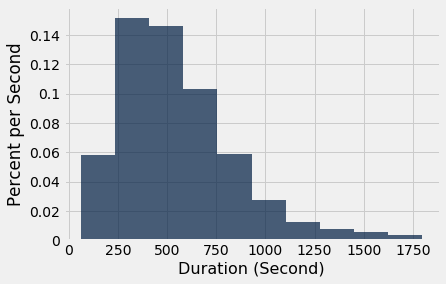

In [3]:
commute = trips.where('Duration', are.below(1800))
commute.hist('Duration', unit='Second')

We can get more detail by specifying a larger number of bins. But the overall shape doesn't change much.

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


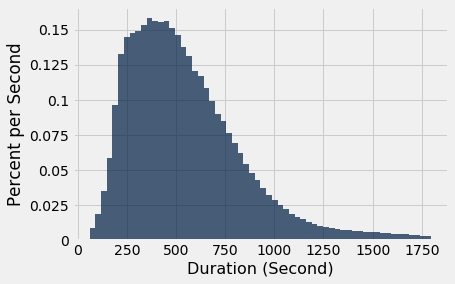

In [4]:
commute.hist('Duration', bins=60, unit='Second')

### Exploring the Data with `group` and `pivot` ###

We can use `group` to identify the most highly used Start Station:

In [5]:
starts = commute.group('Start Station').sort('count', descending=True)
starts

Start Station,count
San Francisco Caltrain (Townsend at 4th),25858
San Francisco Caltrain 2 (330 Townsend),21523
Harry Bridges Plaza (Ferry Building),15543
Temporary Transbay Terminal (Howard at Beale),14298
2nd at Townsend,13674
Townsend at 7th,13579
Steuart at Market,13215
Embarcadero at Sansome,12842
Market at 10th,11523
Market at Sansome,11023


The largest number of trips started at the Caltrain Station on Townsend and 4th in San Francisco. People take the train into the city, and then use a shared bike to get to their next destination.

The `group` method can also be used to classify the rentals by both Start Station and End Station.

In [6]:
commute.group(['Start Station', 'End Station'])

Start Station,End Station,count
2nd at Folsom,2nd at Folsom,54
2nd at Folsom,2nd at South Park,295
2nd at Folsom,2nd at Townsend,437
2nd at Folsom,5th at Howard,113
2nd at Folsom,Beale at Market,127
2nd at Folsom,Broadway St at Battery St,67
2nd at Folsom,Civic Center BART (7th at Market),47
2nd at Folsom,Clay at Battery,240
2nd at Folsom,Commercial at Montgomery,128
2nd at Folsom,Davis at Jackson,28


Fifty-four trips both started and ended at the station on 2nd at Folsom. A much large number (437) were between 2nd at Folsom and 2nd at Townsend. 

The `pivot` method does the same classification but displays its results in a contingency table that shows all possible combinations of Start and End Stations, even though some of them didn't correspond to any trips. Remember that the first argument of a `pivot` statement specifies the column labels of the pivot table; the second argument labels the rows.

There is a train station as well as a Bay Area Rapid Transit (BART) station near Beale at Market, explaining the high number of trips that start and end there.

In [7]:
commute.pivot('Start Station', 'End Station')

End Station,2nd at Folsom,2nd at South Park,2nd at Townsend,5th at Howard,Adobe on Almaden,Arena Green / SAP Center,Beale at Market,Broadway St at Battery St,California Ave Caltrain Station,Castro Street and El Camino Real,Civic Center BART (7th at Market),Clay at Battery,Commercial at Montgomery,Cowper at University,Davis at Jackson,Embarcadero at Bryant,Embarcadero at Folsom,Embarcadero at Sansome,Embarcadero at Vallejo,Evelyn Park and Ride,Franklin at Maple,Golden Gate at Polk,Grant Avenue at Columbus Avenue,Harry Bridges Plaza (Ferry Building),Howard at 2nd,Japantown,MLK Library,Market at 10th,Market at 4th,Market at Sansome,Mechanics Plaza (Market at Battery),Mezes Park,Mountain View Caltrain Station,Mountain View City Hall,Palo Alto Caltrain Station,Park at Olive,Paseo de San Antonio,Post at Kearny,Powell Street BART,Powell at Post (Union Square),Redwood City Caltrain Station,Redwood City Medical Center,Redwood City Public Library,Rengstorff Avenue / California Street,Ryland Park,SJSU - San Salvador at 9th,SJSU 4th at San Carlos,San Antonio Caltrain Station,San Antonio Shopping Center,San Francisco Caltrain (Townsend at 4th),San Francisco Caltrain 2 (330 Townsend),San Francisco City Hall,San Jose City Hall,San Jose Civic Center,San Jose Diridon Caltrain Station,San Mateo County Center,San Pedro Square,San Salvador at 1st,Santa Clara County Civic Center,Santa Clara at Almaden,South Van Ness at Market,Spear at Folsom,St James Park,Stanford in Redwood City,Steuart at Market,Temporary Transbay Terminal (Howard at Beale),Townsend at 7th,University and Emerson,Washington at Kearny,Yerba Buena Center of the Arts (3rd @ Howard)
2nd at Folsom,54,190,554,107,0,0,40,21,0,0,44,78,54,0,9,77,32,41,14,0,0,11,30,416,53,0,0,169,114,302,33,0,0,0,0,0,0,60,121,88,0,0,0,0,0,0,0,0,0,694,445,21,0,0,0,0,0,0,0,0,38,57,0,0,39,237,342,0,17,31
2nd at South Park,295,164,71,180,0,0,208,85,0,0,112,87,160,0,37,56,178,83,116,0,0,57,73,574,500,0,0,139,199,1633,119,0,0,0,0,0,0,299,84,113,0,0,0,0,0,0,0,0,0,559,480,48,0,0,0,0,0,0,0,0,66,152,0,0,374,429,143,0,63,209
2nd at Townsend,437,151,185,92,0,0,608,350,0,0,80,329,168,0,386,361,658,506,254,0,0,27,315,2607,295,0,0,110,225,845,177,0,0,0,0,0,0,120,100,141,0,0,0,0,0,0,0,0,0,905,299,14,0,0,0,0,0,0,0,0,72,508,0,0,2349,784,417,0,57,166
5th at Howard,113,177,148,83,0,0,59,130,0,0,203,76,129,0,30,57,49,166,54,0,0,85,78,371,478,0,0,303,158,168,90,0,0,0,0,0,0,93,183,169,0,0,0,0,0,0,0,0,0,690,1859,48,0,0,0,0,0,0,0,0,116,102,0,0,182,750,200,0,43,267
Adobe on Almaden,0,0,0,0,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,7,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,7,7,16,0,0,0,0,0,19,23,265,0,20,4,5,10,0,0,14,0,0,0,0,0,0,0
Arena Green / SAP Center,0,0,0,0,7,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,5,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,24,3,7,0,0,0,0,0,6,20,7,0,56,12,38,259,0,0,13,0,0,0,0,0,0,0
Beale at Market,127,79,183,59,0,0,59,661,0,0,201,75,101,0,247,178,38,590,165,0,0,54,435,57,72,0,0,286,236,163,26,0,0,0,0,0,0,49,227,179,0,0,0,0,0,0,0,0,0,640,269,25,0,0,0,0,0,0,0,0,243,128,0,0,16,167,35,0,64,45
Broadway St at Battery St,67,89,279,119,0,0,1022,110,0,0,62,283,226,0,191,198,79,231,35,0,0,5,70,168,49,0,0,32,97,341,214,0,0,0,0,0,0,169,71,218,0,0,0,0,0,0,0,0,0,685,438,7,0,0,0,0,0,0,0,0,18,106,0,0,344,748,50,0,79,47
California Ave Caltrain Station,0,0,0,0,0,0,0,0,38,1,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,192,40,0,0,0,0,0,0,0,6,0,0,0,17,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,0,0
Castro Street and El Camino Real,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,931,34,0,0,0,0,0,0,0,0,0,7,0,0,0,4,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can also use `pivot` to find the shortest time of the rides between Start and End Stations. Here `pivot` has been given `Duration` as the optional `values` argument, and `min` as the function which to perform on the values in each cell.

In [8]:
commute.pivot('Start Station', 'End Station', 'Duration', min)

End Station,2nd at Folsom,2nd at South Park,2nd at Townsend,5th at Howard,Adobe on Almaden,Arena Green / SAP Center,Beale at Market,Broadway St at Battery St,California Ave Caltrain Station,Castro Street and El Camino Real,Civic Center BART (7th at Market),Clay at Battery,Commercial at Montgomery,Cowper at University,Davis at Jackson,Embarcadero at Bryant,Embarcadero at Folsom,Embarcadero at Sansome,Embarcadero at Vallejo,Evelyn Park and Ride,Franklin at Maple,Golden Gate at Polk,Grant Avenue at Columbus Avenue,Harry Bridges Plaza (Ferry Building),Howard at 2nd,Japantown,MLK Library,Market at 10th,Market at 4th,Market at Sansome,Mechanics Plaza (Market at Battery),Mezes Park,Mountain View Caltrain Station,Mountain View City Hall,Palo Alto Caltrain Station,Park at Olive,Paseo de San Antonio,Post at Kearny,Powell Street BART,Powell at Post (Union Square),Redwood City Caltrain Station,Redwood City Medical Center,Redwood City Public Library,Rengstorff Avenue / California Street,Ryland Park,SJSU - San Salvador at 9th,SJSU 4th at San Carlos,San Antonio Caltrain Station,San Antonio Shopping Center,San Francisco Caltrain (Townsend at 4th),San Francisco Caltrain 2 (330 Townsend),San Francisco City Hall,San Jose City Hall,San Jose Civic Center,San Jose Diridon Caltrain Station,San Mateo County Center,San Pedro Square,San Salvador at 1st,Santa Clara County Civic Center,Santa Clara at Almaden,South Van Ness at Market,Spear at Folsom,St James Park,Stanford in Redwood City,Steuart at Market,Temporary Transbay Terminal (Howard at Beale),Townsend at 7th,University and Emerson,Washington at Kearny,Yerba Buena Center of the Arts (3rd @ Howard)
2nd at Folsom,61,97,164,268,0,0,271,407,0,0,483,329,306,0,494,239,262,687,599,0,0,639,416,282,80,0,0,506,237,167,250,0,0,0,0,0,0,208,264,290,0,0,0,0,0,0,0,0,0,300,303,584,0,0,0,0,0,0,0,0,590,208,0,0,318,149,448,0,429,165
2nd at South Park,61,60,77,86,0,0,78,345,0,0,290,188,171,0,357,104,81,490,341,0,0,369,278,122,60,0,0,416,142,61,68,0,0,0,0,0,0,60,237,106,0,0,0,0,0,0,0,0,0,63,66,458,0,0,0,0,0,0,0,0,399,63,0,0,79,61,78,0,270,96
2nd at Townsend,137,67,60,423,0,0,311,469,0,0,546,520,474,0,436,145,232,509,494,0,0,773,549,325,221,0,0,667,367,265,395,0,0,0,0,0,0,319,455,398,0,0,0,0,0,0,0,0,0,125,133,742,0,0,0,0,0,0,0,0,777,241,0,0,291,249,259,0,610,284
5th at Howard,215,300,384,68,0,0,357,530,0,0,179,412,364,0,543,419,359,695,609,0,0,235,474,453,145,0,0,269,161,250,306,0,0,0,0,0,0,234,89,202,0,0,0,0,0,0,0,0,0,256,221,347,0,0,0,0,0,0,0,0,375,402,0,0,455,265,357,0,553,109
Adobe on Almaden,0,0,0,0,84,275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,701,387,0,0,0,0,0,0,0,0,0,229,0,0,0,0,0,0,0,441,452,318,0,0,0,0,0,309,146,182,0,207,358,876,101,0,0,369,0,0,0,0,0,0,0
Arena Green / SAP Center,0,0,0,0,305,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,526,546,0,0,0,0,0,0,0,0,0,403,0,0,0,0,0,0,0,288,875,685,0,0,0,0,0,440,420,153,0,166,624,759,116,0,0,301,0,0,0,0,0,0,0
Beale at Market,219,343,417,387,0,0,60,155,0,0,343,122,153,0,115,216,170,303,198,0,0,437,235,149,204,0,0,535,203,88,72,0,0,0,0,0,0,191,316,191,0,0,0,0,0,0,0,0,0,499,395,526,0,0,0,0,0,0,0,0,575,173,0,0,87,94,619,0,222,264
Broadway St at Battery St,351,424,499,555,0,0,195,62,0,0,520,90,129,0,70,340,284,128,101,0,0,961,148,168,357,0,0,652,351,218,221,0,0,0,0,0,0,255,376,316,0,0,0,0,0,0,0,0,0,611,599,799,0,0,0,0,0,0,0,0,738,336,0,0,169,291,885,0,134,411
California Ave Caltrain Station,0,0,0,0,0,0,0,0,82,1645,0,0,0,628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1771,0,484,131,0,0,0,0,0,0,0,1077,0,0,0,870,911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,531,0,0
Castro Street and El Camino Real,0,0,0,0,0,0,0,0,0,74,0,0,0,0,0,0,0,0,0,499,0,0,0,0,0,0,0,0,0,0,0,0,201,108,0,0,0,0,0,0,0,0,0,654,0,0,0,953,696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Someone had a very quick trip (271 seconds, or about 4.5 minutes) from 2nd at Folsom to Beale at Market, about five blocks away. There are no bike trips between the 2nd Avenue stations and Adobe on Almaden, because the latter is in a different city.

### Drawing Maps ###
The table `stations` contains geographical information about each bike station, including latitude, longitude, and a "landmark" which is the name of the city where the station is located.

In [9]:
stations = Table.read_table(path_data + 'station.csv')
stations

station_id,name,lat,long,dockcount,landmark,installation
2,San Jose Diridon Caltrain Station,37.3297,-121.902,27,San Jose,8/6/2013
3,San Jose Civic Center,37.3307,-121.889,15,San Jose,8/5/2013
4,Santa Clara at Almaden,37.334,-121.895,11,San Jose,8/6/2013
5,Adobe on Almaden,37.3314,-121.893,19,San Jose,8/5/2013
6,San Pedro Square,37.3367,-121.894,15,San Jose,8/7/2013
7,Paseo de San Antonio,37.3338,-121.887,15,San Jose,8/7/2013
8,San Salvador at 1st,37.3302,-121.886,15,San Jose,8/5/2013
9,Japantown,37.3487,-121.895,15,San Jose,8/5/2013
10,San Jose City Hall,37.3374,-121.887,15,San Jose,8/6/2013
11,MLK Library,37.3359,-121.886,19,San Jose,8/6/2013


We can draw a map of where the stations are located, using `Marker.map_table`. The function operates on a table, whose columns are (in order) latitude, longitude, and an optional identifier for each point.

In [10]:
Marker.map_table(stations.select('lat', 'long', 'name'))

/mnt/c/Users/chold/github/forks/python/teaching/dsep/datascience/datascience/maps.py:368: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
  f(**self._folium_kwargs)


The map is created using [OpenStreetMap](http://www.openstreetmap.org/#map=5/51.500/-0.100), which is an open online mapping system that you can use just as you would use Google Maps or any other online map. Zoom in to San Francisco to see how the stations are distributed. Click on a marker to see which station it is.

You can also represent points on a map by colored circles. Here is such a map of the San Francisco bike stations.

In [11]:
sf = stations.where('landmark', are.equal_to('San Francisco'))
sf_map_data = sf.select('lat', 'long', 'name')
Circle.map_table(sf_map_data, color='green', radius=200)

/mnt/c/Users/chold/github/forks/python/teaching/dsep/datascience/datascience/maps.py:368: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
  f(**self._folium_kwargs)


### More Informative Maps: An Application of `join` ###
The bike stations are located in five different cities in the Bay Area. To distinguish the points by using a different color for each city, let's start by using group to identify all the cities and assign each one a color.

In [12]:
cities = stations.group('landmark').relabeled('landmark', 'city')
cities

city,count
Mountain View,7
Palo Alto,5
Redwood City,7
San Francisco,35
San Jose,16


In [13]:
colors = cities.with_column('color', make_array('blue', 'red', 'green', 'orange', 'purple'))
colors

city,count,color
Mountain View,7,blue
Palo Alto,5,red
Redwood City,7,green
San Francisco,35,orange
San Jose,16,purple


Now we can join `stations` and `colors` by `landmark`, and then select the columns we need to draw a map.

In [14]:
joined = stations.join('landmark', colors, 'city')
colored = joined.select('lat', 'long', 'name', 'color')
Marker.map_table(colored)

/mnt/c/Users/chold/github/forks/python/teaching/dsep/datascience/datascience/maps.py:368: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
  f(**self._folium_kwargs)


Now the markers have five different colors for the five different cities.

To see where most of the bike rentals originate, let's identify the start stations:

In [15]:
starts = commute.group('Start Station').sort('count', descending=True)
starts

Start Station,count
San Francisco Caltrain (Townsend at 4th),25858
San Francisco Caltrain 2 (330 Townsend),21523
Harry Bridges Plaza (Ferry Building),15543
Temporary Transbay Terminal (Howard at Beale),14298
2nd at Townsend,13674
Townsend at 7th,13579
Steuart at Market,13215
Embarcadero at Sansome,12842
Market at 10th,11523
Market at Sansome,11023


We can include the geographical data needed to map these stations, by first joining `starts` with `stations`:

In [16]:
station_starts = stations.join('name', starts, 'Start Station')
station_starts

name,station_id,lat,long,dockcount,landmark,installation,count
2nd at Folsom,62,37.7853,-122.396,19,San Francisco,8/22/2013,7841
2nd at South Park,64,37.7823,-122.393,15,San Francisco,8/22/2013,9274
2nd at Townsend,61,37.7805,-122.39,27,San Francisco,8/22/2013,13674
5th at Howard,57,37.7818,-122.405,15,San Francisco,8/21/2013,7394
Adobe on Almaden,5,37.3314,-121.893,19,San Jose,8/5/2013,522
Arena Green / SAP Center,14,37.3327,-121.9,19,San Jose,8/5/2013,590
Beale at Market,56,37.7923,-122.397,19,San Francisco,8/20/2013,8135
Broadway St at Battery St,82,37.7985,-122.401,15,San Francisco,1/22/2014,7460
California Ave Caltrain Station,36,37.4291,-122.143,15,Palo Alto,8/14/2013,300
Castro Street and El Camino Real,32,37.386,-122.084,11,Mountain View,12/31/2013,1137


Now we extract just the data needed for drawing our map, adding a color and an area to each station. The area is 1000 times the count of the number of rentals starting at each station, where the constant 1000 was chosen so that the circles would appear at an appropriate scale on the map.

In [17]:
starts_map_data = station_starts.select('lat', 'long', 'name').with_columns(
    'color', 'blue',
    'area', station_starts.column('count') * 1000
)
starts_map_data.show(3)
Circle.map_table(starts_map_data)

lat,long,name,color,area
37.7853,-122.396,2nd at Folsom,blue,7841000
37.7823,-122.393,2nd at South Park,blue,9274000
37.7805,-122.39,2nd at Townsend,blue,13674000


/mnt/c/Users/chold/github/forks/python/teaching/dsep/datascience/datascience/maps.py:368: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
  f(**self._folium_kwargs)


That huge blob in San Francisco shows that the eastern section of the city is the unrivaled capital of bike rentals in the Bay Area.